<a href="https://colab.research.google.com/github/alumican/stable-diffusion/blob/main/stable_diffuion_quick_start.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Reference

https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb

https://github.com/CompVis/stable-diffusion

### Install Dependencies

**GPUが利用可能か確認する**

In [ ]:
!nvidia-smi

Mon Aug 29 11:36:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    27W /  70W |   3276MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

failedの場合は `ランタイム` > `ランタイムのタイプを変更` > `ハードウェア アクセラレータ` > `GPU` に設定する

**ライブラリをインストールする**

In [ ]:
!pip install diffusers==0.2.4
!pip install transformers scipy ftfy
!pip install "ipywidgets>=7,<8"

!git clone https://github.com/huggingface/diffusers.git
!pip install git+https://github.com/huggingface/diffusers.git

!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'diffusers' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-z5otsci6
  Running command git clone -q https://github.com/huggingface/diffusers.git /tmp/pip-req-build-z5otsci6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Login to HuggingFace

Google Colabから外部サービスへログインするために外部ウィジェットを有効化する

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

アクセストークンを使ってログインする

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


モデルの利用規約に同意する
https://huggingface.co/CompVis/stable-diffusion-v1-4

### Create Pipeline (text to image)

In [ ]:
import torch

# text to image
from diffusers import StableDiffusionPipeline
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16, use_auth_token=True)
pipe = pipe.to("cuda")

### Create Pipeline (image to image)

In [ ]:
import inspect
from typing import List, Optional, Union

import numpy as np
import torch

import PIL
from diffusers import AutoencoderKL, DDIMScheduler, DiffusionPipeline, PNDMScheduler, UNet2DConditionModel
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer


def preprocess(image):
    w, h = image.size
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((w, h), resample=PIL.Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.0 * image - 1.0


class StableDiffusionImg2ImgPipeline(DiffusionPipeline):
    def __init__(
        self,
        vae: AutoencoderKL,
        text_encoder: CLIPTextModel,
        tokenizer: CLIPTokenizer,
        unet: UNet2DConditionModel,
        scheduler: Union[DDIMScheduler, PNDMScheduler],
        safety_checker: StableDiffusionSafetyChecker,
        feature_extractor: CLIPFeatureExtractor,
    ):
        super().__init__()
        scheduler = scheduler.set_format("pt")
        self.register_modules(
            vae=vae,
            text_encoder=text_encoder,
            tokenizer=tokenizer,
            unet=unet,
            scheduler=scheduler,
            safety_checker=safety_checker,
            feature_extractor=feature_extractor,
        )

    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]],
        init_image: torch.FloatTensor,
        strength: float = 0.8,
        num_inference_steps: Optional[int] = 50,
        guidance_scale: Optional[float] = 7.5,
        eta: Optional[float] = 0.0,
        generator: Optional[torch.Generator] = None,
        output_type: Optional[str] = "pil",
    ):

        if isinstance(prompt, str):
            batch_size = 1
        elif isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            raise ValueError(f"`prompt` has to be of type `str` or `list` but is {type(prompt)}")

        if strength < 0 or strength > 1:
            raise ValueError(f"The value of strength should in [0.0, 1.0] but is {strength}")

        # set timesteps
        accepts_offset = "offset" in set(inspect.signature(self.scheduler.set_timesteps).parameters.keys())
        extra_set_kwargs = {}
        offset = 0
        if accepts_offset:
            offset = 1
            extra_set_kwargs["offset"] = 1

        self.scheduler.set_timesteps(num_inference_steps, **extra_set_kwargs)

        # encode the init image into latents and scale the latents
        init_latents = self.vae.encode(init_image.to(self.device)).sample()
        init_latents = 0.18215 * init_latents

        # prepare init_latents noise to latents
        init_latents = torch.cat([init_latents] * batch_size)

        # get the original timestep using init_timestep
        init_timestep = int(num_inference_steps * strength) + offset
        init_timestep = min(init_timestep, num_inference_steps)
        timesteps = self.scheduler.timesteps[-init_timestep]
        timesteps = torch.tensor([timesteps] * batch_size, dtype=torch.long, device=self.device)

        # add noise to latents using the timesteps
        noise = torch.randn(init_latents.shape, generator=generator, device=self.device)
        init_latents = self.scheduler.add_noise(init_latents, noise, timesteps)

        # get prompt text embeddings
        text_input = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_embeddings = self.text_encoder(text_input.input_ids.to(self.device))[0]

        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0
        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance:
            max_length = text_input.input_ids.shape[-1]
            uncond_input = self.tokenizer(
                [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
            )
            uncond_embeddings = self.text_encoder(uncond_input.input_ids.to(self.device))[0]

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

        # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
        # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
        # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
        # and should be between [0, 1]
        accepts_eta = "eta" in set(inspect.signature(self.scheduler.step).parameters.keys())
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta

        latents = init_latents
        t_start = max(num_inference_steps - init_timestep + offset, 0)
        for i, t in tqdm(enumerate(self.scheduler.timesteps[t_start:])):
            # expand the latents if we are doing classifier free guidance
            latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents

            # predict the noise residual
            noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs)["prev_sample"]

        # scale and decode the image latents with vae
        latents = 1 / 0.18215 * latents
        image = self.vae.decode(latents)

        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()

        # run safety checker
        safety_cheker_input = self.feature_extractor(self.numpy_to_pil(image), return_tensors="pt").to(self.device)
        image, has_nsfw_concept = self.safety_checker(images=image, clip_input=safety_cheker_input.pixel_values)

        if output_type == "pil":
            image = self.numpy_to_pil(image)

        return {"sample": image, "nsfw_content_detected": has_nsfw_concept}

In [ ]:
# image to image
img2imgPipe = StableDiffusionImg2ImgPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16",  torch_dtype=torch.float16, use_auth_token=True)
img2imgPipe = img2imgPipe.to("cuda")

### Create Pipeline (inpainting)

In [ ]:
import inspect
from typing import List, Optional, Union

import numpy as np
import torch

import PIL
from diffusers import AutoencoderKL, DDIMScheduler, DiffusionPipeline, PNDMScheduler, UNet2DConditionModel
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer


def preprocess_image(image):
    w, h = image.size
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((w, h), resample=PIL.Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.0 * image - 1.0


def preprocess_mask(mask):
    mask = mask.convert("L")
    w, h = mask.size
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    mask = mask.resize((w // 8, h // 8), resample=PIL.Image.NEAREST)
    mask = np.array(mask).astype(np.float32) / 255.0
    mask = np.tile(mask, (4, 1, 1))
    mask = mask[None].transpose(0, 1, 2, 3)  # what does this step do?
    mask = 1 - mask  # repaint white, keep black
    mask = torch.from_numpy(mask)
    return mask


class StableDiffusionInpaintingPipeline(DiffusionPipeline):
    def __init__(
        self,
        vae: AutoencoderKL,
        text_encoder: CLIPTextModel,
        tokenizer: CLIPTokenizer,
        unet: UNet2DConditionModel,
        scheduler: Union[DDIMScheduler, PNDMScheduler],
        safety_checker: StableDiffusionSafetyChecker,
        feature_extractor: CLIPFeatureExtractor,
    ):
        super().__init__()
        scheduler = scheduler.set_format("pt")
        self.register_modules(
            vae=vae,
            text_encoder=text_encoder,
            tokenizer=tokenizer,
            unet=unet,
            scheduler=scheduler,
            safety_checker=safety_checker,
            feature_extractor=feature_extractor,
        )

    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]],
        init_image: torch.FloatTensor,
        mask_image: torch.FloatTensor,
        strength: float = 0.8,
        num_inference_steps: Optional[int] = 50,
        guidance_scale: Optional[float] = 7.5,
        eta: Optional[float] = 0.0,
        generator: Optional[torch.Generator] = None,
        output_type: Optional[str] = "pil",
    ):

        if isinstance(prompt, str):
            batch_size = 1
        elif isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            raise ValueError(f"`prompt` has to be of type `str` or `list` but is {type(prompt)}")

        if strength < 0 or strength > 1:
            raise ValueError(f"The value of strength should in [0.0, 1.0] but is {strength}")

        # set timesteps
        accepts_offset = "offset" in set(inspect.signature(self.scheduler.set_timesteps).parameters.keys())
        extra_set_kwargs = {}
        offset = 0
        if accepts_offset:
            offset = 1
            extra_set_kwargs["offset"] = 1

        self.scheduler.set_timesteps(num_inference_steps, **extra_set_kwargs)

        # preprocess image
        init_image = preprocess_image(init_image).to(self.device)

        # encode the init image into latents and scale the latents
        init_latents = self.vae.encode(init_image).sample()
        init_latents = 0.18215 * init_latents

        # prepare init_latents noise to latents
        init_latents = torch.cat([init_latents] * batch_size)
        init_latents_orig = init_latents

        # preprocess mask
        mask = preprocess_mask(mask_image).to(self.device)
        mask = torch.cat([mask] * batch_size)

        # check sizes
        if not mask.shape == init_latents.shape:
            raise ValueError(f"The mask and init_image should be the same size!")

        # get the original timestep using init_timestep
        init_timestep = int(num_inference_steps * strength) + offset
        init_timestep = min(init_timestep, num_inference_steps)
        timesteps = self.scheduler.timesteps[-init_timestep]
        timesteps = torch.tensor([timesteps] * batch_size, dtype=torch.long, device=self.device)

        # add noise to latents using the timesteps
        noise = torch.randn(init_latents.shape, generator=generator, device=self.device)
        init_latents = self.scheduler.add_noise(init_latents, noise, timesteps)

        # get prompt text embeddings
        text_input = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_embeddings = self.text_encoder(text_input.input_ids.to(self.device))[0]

        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0
        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance:
            max_length = text_input.input_ids.shape[-1]
            uncond_input = self.tokenizer(
                [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
            )
            uncond_embeddings = self.text_encoder(uncond_input.input_ids.to(self.device))[0]

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

        # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
        # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
        # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
        # and should be between [0, 1]
        accepts_eta = "eta" in set(inspect.signature(self.scheduler.step).parameters.keys())
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta

        latents = init_latents
        t_start = max(num_inference_steps - init_timestep + offset, 0)
        for i, t in tqdm(enumerate(self.scheduler.timesteps[t_start:])):
            # expand the latents if we are doing classifier free guidance
            latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents

            # predict the noise residual
            noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs)["prev_sample"]

            # masking
            init_latents_proper = self.scheduler.add_noise(init_latents_orig, noise, t)
            latents = (init_latents_proper * mask) + (latents * (1 - mask))

        # scale and decode the image latents with vae
        latents = 1 / 0.18215 * latents
        image = self.vae.decode(latents)

        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()

        # run safety checker
        safety_cheker_input = self.feature_extractor(self.numpy_to_pil(image), return_tensors="pt").to(self.device)
        image, has_nsfw_concept = self.safety_checker(images=image, clip_input=safety_cheker_input.pixel_values)

        if output_type == "pil":
            image = self.numpy_to_pil(image)

        return {"sample": image, "nsfw_content_detected": has_nsfw_concept}

In [ ]:
#inpainting
inpaintingPipe = StableDiffusionInpaintingPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16",  torch_dtype=torch.float16, use_auth_token=True)
inpaintingPipe = inpaintingPipe.to("cuda")

def dummy(images, **kwargs):
  return images, False

inpaintingPipe.safety_checker = dummy

### Utility Functions

In [ ]:
# --------------------
from torch import autocast

def generate_image(prompt, width=512, height=512):
  with autocast("cuda"):
    image = pipe(prompt, width=width, height=height)["sample"][0]
  return image

def generate_images(count, prompt, width=512, height=512):
  with autocast("cuda"):
    images = pipe([prompt] * count, width=width, height=height)["sample"]
  return images

def generate_img2img(prompt, init_image, strength=0.75, guidance_scale=7.5, width=512, height=512):
  init_image_2 = init_image.resize((width, height))
  init_image_2 = preprocess(init_image_2)
  with autocast("cuda"):
    image = img2imgPipe(prompt, init_image=init_image_2, strength=strength, guidance_scale=guidance_scale)["sample"][0]
  return image

def generate_img2imgs(count, prompt, init_image, strength=0.75, guidance_scale=7.5, width=512, height=512):
  init_image_2 = init_image.resize((width, height))
  init_image_2 = preprocess(init_image_2)
  with autocast("cuda"):
    images = pipe([prompt] * count, init_image=init_image_2, strength=strength, guidance_scale=guidance_scale, width=width, height=height)["sample"]
  return images

# --------------------
from PIL import Image
import math

def show_images(images, col_count=1):
  row_count = math.ceil(len(images) / col_count)
  image_w, image_h = images[0].size
  extended_image = Image.new("RGBA", size=(image_w * col_count, image_h * row_count), color=(0, 0, 0, 0))
  for i, image in enumerate(images):
    x_index = i % col_count
    y_index = i // col_count
    extended_image.paste(image, box=(x_index * image_w, y_index * image_h))
  return extended_image

# --------------------
def save_image(image, path):
  image.save(path)

# --------------------
from google.colab import files
import os
import shutil

def upload_files(directory_path="."):
  uploaded_files = files.upload()
  uploaded_file_names = list(uploaded_files.keys())
  uploaded_file_names.sort()
  saved_file_paths = []
  for i in range(len(uploaded_file_names)):
    os.makedirs(directory_path, exist_ok=True)
    file_name = uploaded_file_names[i]
    saved_file_path = directory_path + "/" + file_name
    shutil.move(file_name, saved_file_path)
    saved_file_paths.append(saved_file_path)
  return saved_file_paths

### Text to Image Examples

0it [00:00, ?it/s]

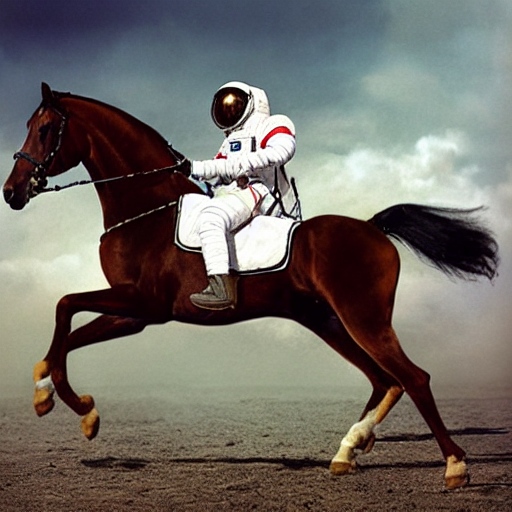

In [ ]:
# generate single image
image = generate_image("a photograph of an astronaut riding a horse")
image

In [ ]:
save_image(image, f"sd_output_sample/astronaut_rides_horse.png")

In [ ]:
# generate multiple image
images = generate_images(3, "a photograph of an astronaut riding a horse")

0it [00:00, ?it/s]

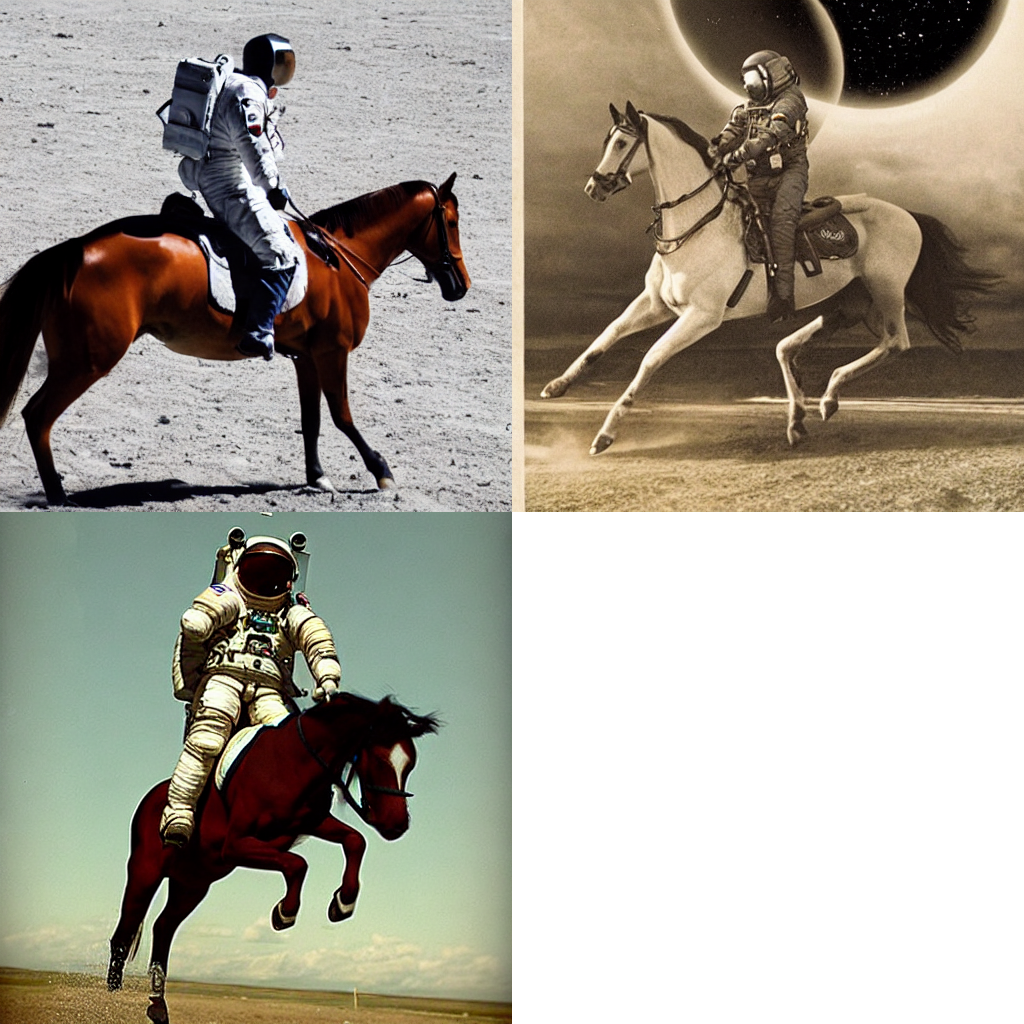

In [ ]:
show_images(images, 2)

### Image to Image Examples

In [ ]:
print("Upload original image")
uploaded_file_paths = upload_files("img2img")

prompt = "A fantasy landscape, trending on artstation"
strength = 0.75
guidance_scale = 7.5
width = 512
height = 512

if (len(uploaded_file_paths) > 0):
  init_image_path = uploaded_file_paths[0]
  print("Init image : " + init_image_path)

  init_image = Image.open(init_image_path)
  generated_image = generate_img2img(prompt, init_image=init_image, strength=strength, guidance_scale=guidance_scale);
  generated_image
  save_image(generated_image, f"img2img/out.png")

else:
  print("Upload failure")

Upload original image


Saving sketch-mountains-input.jpg to sketch-mountains-input.jpg
Init image : img2img/sketch-mountains-input.jpg


0it [00:00, ?it/s]

In [ ]:
import gradio as gr
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, LMSDiscreteScheduler
import requests
from PIL import Image
from io import BytesIO
from IPython.display import clear_output ###


block = gr.Blocks(css=".container { max-width: 800px; margin: auto; }")

num_samples = 2





def infer(prompt, init_image, strength):
    if init_image != None:
        init_image = init_image.resize((512, 512))
        init_image = preprocess(init_image)
        with autocast("cuda"):
            images = img2imgPipe([prompt] * num_samples, init_image=init_image, strength=strength, guidance_scale=7.5)["sample"]
    else: 
        with autocast("cuda"):
            images = img2imgPipe([prompt] * num_samples, guidance_scale=7.5)["sample"]

    return images





with block as demo:
    gr.Markdown("<h1><center>Stable Diffusion</center></h1>")
    gr.Markdown(
        "Stable Diffusion is an AI model that generates images from any prompt you give!"
    )
    with gr.Group():
        with gr.Box():
            with gr.Row().style(mobile_collapse=False, equal_height=True):

                text = gr.Textbox(
                    label="Enter your prompt", show_label=False, max_lines=1
                ).style(
                    border=(True, False, True, True),
                    rounded=(True, False, False, True),
                    container=False,
                )
                btn = gr.Button("Run").style(
                    margin=False,
                    rounded=(False, True, True, False),
                )
        strength_slider = gr.Slider(
            label="Strength",
            maximum = 1,
            value = 0.75         
        )
        image = gr.Image(
            label="Intial Image",
            type="pil"
        )
               
        gallery = gr.Gallery(label="Generated images", show_label=False).style(
            grid=[2], height="auto"
        )
        text.submit(infer, inputs=[text,image,strength_slider], outputs=gallery)
        btn.click(infer, inputs=[text,image,strength_slider], outputs=gallery)

    gr.Markdown(
        """___
   <p style='text-align: center'>
   Created by CompVis and Stability AI
   <br/>
   </p>"""
    )

clear_output() ###
demo.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://59970.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


0it [00:00, ?it/s]

Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7f5f26e81710>,
 'http://127.0.0.1:7860/',
 'https://59970.gradio.app')